***
**Algorithmes d'optimisation -- L3 MINT et doubles licences 2018/2019 -- Université Paris-Sud**
***
$\newcommand{\Rsp}{\mathbb{R}} \newcommand{\nr}[1]{\|#1\|} \newcommand{\abs}[1]{|#1|} \newcommand{\eps}{\varepsilon} \newcommand{\sca}[2]{\langle#1|#2\rangle} \newcommand{\D}{\mathrm{D}} \newcommand{\hdots}{\dots} \newcommand{\cond}{\mathrm{cond}}$
On commence par importer les modules habituels:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# la commande suivante agrandit les figures
plt.rcParams['figure.figsize'] = [9.,6.]

def verifier_gradient(f,g,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-4
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numerique dans le calcul du gradient: %g (doit etre petit)' % np.linalg.norm(g(x0)-gg))

# TP 3: Pénalisation et gradient projeté


## Partie I: Problème d'obstacle par gradient projeté

On considère un système physique constitué d'une chaine de $N+1$ ressorts. Les deux extrémités du $i$ème ressort ($0\leq i\leq N$ sont les points $(t_i,x_i) \in\Rsp^2$ et $(t_{i+1},x_{i+1}) \in \Rsp^2$, où $t_i = hi$ est fixé.  On considère également que la chaine est fixée à ses extrémités: $x_0 = x_{N+1} = 0$. Il reste donc $N$ inconnues $x = (x_1,\hdots,x_N)\in \Rsp^N$. L'énergie du système est donnée par la formule suivante:

$$J(x) = J(x_1,\hdots,x_N) = \frac{1}{2}\sum_{0\leq i\leq N-1} \nr{x_{i+1} - x_i}^2 $$ 

où l'on a donc fixé $x_0 = x_{N+1} = 0$. On pose un obstacle sous la chaîne de ressort, qui force chacune des coordonnées $x_i$ a être minorée par une constante $f_i$ (on peut penser à une main qui pousse le ressort par exemple). On arrive dont au problème d'optimisation

$$ \min_{x\in K} J(x) \hbox{ où } K = \{x\in \Rsp^N \mid \forall 1\leq i\leq N, x_i \geq f_i \}. $$

Nous allons la résolution numérique de ce problème d'optimisation par la méthode de gradient projeté. On rappelle les formules suivantes:

- La projection d'un point $y\in\Rsp^d$ sur le convexe fermé $K$ est donnée par 

$$ P_K(y) = (\max(y_N,f_N),\hdots,\max(y_N,f_N)) $$

- On admet que la fonction $J$ peut être mise sous la forme

$$ J(x) = \frac{1}{2} \sca{x}{Q x}  \hbox{ où } Q = \begin{pmatrix}2 & -1  & 0 &\cdots & 0 \\
-1 & 2 & -1 & \ddots & \vdots   \\ 
0 & \ddots & \ddots & \ddots& \vdots \\
\vdots & \ddots & -1 & 2 & -1 \\
0 & \hdots & 0 & -1 & 2
\end{pmatrix}$$

Le gradient de la fonction  $J$ en $x\in \Rsp^N$ est alors donné par $\nabla J(x) = Q x.$

**Q1)** Écrire une fonction projK(x) retournant la projection de $x\in \Rsp^N$ sur $K$ (la tester avec des petites valeurs de $N$). On fixe désormais $N=30$: écrire la matrice $Q$ et deux fonctions `J(x)` et `gradJ(x)` calculant la valeur et le gradient de $J$. Vérifier le calcul du gradient avec `check_gradient`.

erreur numerique dans le calcul du gradient: 9.171e-12 (doit etre petit)


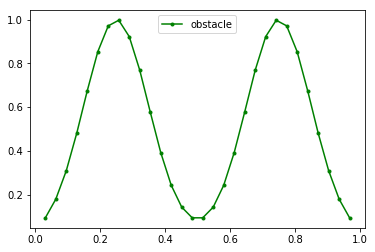

In [13]:
# initialiser les variables K,Q, x0, fmin
N = 30
T = np.linspace(0,1,N+2)[1:-1]
F = np.exp(-50*(T-.75)**2) + np.exp(-50*(T-.25)**2)
plt.plot(T,F,'.-g',label='obstacle')

plt.legend()

Q = 2*np.eye(N) - np.eye(N,N,1) - np.eye(N,N,-1)

def projK(x):
    return np.maximum(x,F)
def J(x):
    return .5*np.dot(np.dot(Q,x),x)
def gradJ(x):
    return np.dot(Q,x)
verifier_gradient(J,gradJ,np.random.rand(N))


[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]


On rappelle que l'algorithme du gradient projeté est défini de la manière suivante:

$$ \begin{cases}
x^{(0)} \in \Rsp^N\\
x^{(k+1)} = P_K\left(x^{(k)} - \tau \nabla J(x^{(k)})\right)
\end{cases} $$

où $\tau>0$. On a démontré en cours que si 

$$ \forall x\in \Rsp^M, m\mathrm{Id} \leq \D^2 J(x) \leq M\mathrm{Id} , $$

alors l'algorithme converge dès que $\tau < 2m/M^2$, avec un taux optimal lorsque $\tau^* = m/M^2$.

**Q2)** Montrer que $\D^2 J(x) = Q$; calculer les valeurs propres de $Q$ via la fonction np.linalg.eigvalsh. Quelle valeur de $\tau^*$ l'estimation ci-dessus donne-t-elle? 

In [15]:
eigv = np.linalg.eigvalsh(Q)
M = np.max(eigv)
m = np.min(eigv)
print('taux optimal : %g' %  (m/M**2))


taux optimal : 0.000644638


**Q3)** Écrire une boucle réalisant l'algorithme du gradient projeté (pour $1\leq k\leq 500$), et stockant le vecteur $G=(\nr{x^{(k+1)} - x^{(k)}})$ (comme il s'agit d'un algorithme de point fixe, c'est une bonne manière de quantifier la convergence). Tracer la solution $x \in \Rsp^N$ trouvée toutes les 20 itérations (on suggère plt.plot(T,x)).  Tester pour $\tau = \tau^*$. En pratique, vérifier que l'algorithme converge toujours $\tau=0.5$ mais diverge pour $\tau$ trop grand.

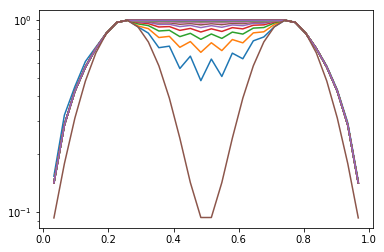

In [39]:
x = np.zeros(N)
s = .5
tau = m/M**2
G = []
x = np.random.rand(N)
for i in range(1,501):
    x2 = projK(x-s*gradJ(x))
    G.append(np.linalg.norm(x2-x))
    x = x2
    if i%20 == 0:
        plt.semilogy(T,x)

plt.semilogy(T,F)


**Q4**) Comme $\nabla J(x) = Qx$, l'algorithme peut en fait être décrit par

$$ \begin{cases}
x^{(0)} \in \Rsp^N\\
x^{(k+1)} = P_K(A_\tau x^{(k)}) 
\end{cases} $$

où $A_\tau = \mathrm{Id}_N - \tau Q$. Montrer que si toutes les valeurs propres de $A_\tau$ sont de module $<1$, alors l'application $x\mapsto A_\tau x$ est contractante. Vérifier numériquement ce critère pour $\tau=0.5$ (on utilisera np.linalg.eigvalsh pour calculer les valeurs propres).

In [40]:
tau = .5
Atau = np.eye(N) - tau*Q
np.max(np.abs(np.linalg.eigvalsh(Atau)))


0.9948693233918954

In [ ]:
while(1):
    

# Problème d'obstacle par pénalisation

Une autre manière d'approcher la solution d'un problème d'optimisation sous contrainte consiste à *pénaliser* la violation des contraintes. Plus précisément, on rajoute à la fonctionnelle $J$ un terme par contrainte d'inégalité $x_i >= F_i$, de la forme $P_i(x) = \frac{1}{\eps} \max(F_i - x_i, 0)^2$ où $\eps>0$: 

- Si le point $x = (x_1,\hdots,x_N)$ vérifie $x_i\geq F_i$, alors $P_i(x) = 0$. 
- Par contre, si $x_i < F_i$ (et ne satisfait pas la contrainte), alors $P_i(x) \geq \frac{1}{\eps} (F_i - x_i)^2$

Ainsi, on considère le problème de minimisation

$$P_\eps := \min_{x\in\Rsp^d} J_\eps(x) \hbox{ où } J_\eps(x) = J(x) + \frac{1}{\eps} \sum_{1\leq i\leq N} \max(F_i - x_i,0)^2. $$

on admettra que 

$$\nabla J_\eps(x) = \nabla J(x) - \frac{2}{\eps} \sum_{1\leq i\leq N} \max(F_i - x_i, 0) e_i $$


**Q1)** Écrire deux fonctions `Jeps`/`gradJeps` calculant $J_\eps/\nabla J_\eps$. Vérifier le calcul du gradient en utilisant `verifier_gradient`.

In [41]:
def Jeps(x,eps):
    return J(x) + (1./eps)*np.sum(np.maximum(F-x,0)**2)

def gradJeps(x,eps): 
    return gradJ(x) - (2./eps)*np.maximum(F-x,0)

x0 = np.random.rand(N)
verifier_gradient(lambda x: Jeps(x,1), 
               lambda x: gradJeps(x,1),x0)


erreur numerique dans le calcul du gradient: 9.85086e-12 (doit etre petit)


**Q2)** Résoudre le problème $P_\eps$ par descente de gradient avec rebroussement (on fournit la fonction `gradient_armijo`) pour $\eps=1,0.1,0.01,0.001$. Interpréter l'explosion du nombre d'itérations.

In [ ]:
def rebroussement_armijo(f,x,d,m,alpha=0.3,beta=0.5):
    t = 1
    while f(x+t*d) > f(x) + alpha*t*m:
        t = beta*t
    return t

def gradient_armijo(f,g,x0,err=1e-5,maxiter=2000):
    x = x0.copy()
    fiter = []
    giter = []
    k = 0 # nombre d'itérations
    while(True): 
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        d = -g(x)
        fiter.append(f(x))
        giter.append(np.linalg.norm(d))
        if np.linalg.norm(d) <= err:
            break
        t = rebroussement_armijo(f,x,d,-np.linalg.norm(d)**2)
        #if k%10==0: # on affiche des informations toute les 20 itérations
        #    print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(d),t))
        x = x + t*d
    return x,np.array(fiter),np.array(giter)

# <completer>
